In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from notebook2.notebook2 import X_train

In [8]:
adelaide_df = pd.read_csv('Adelaide_Data.csv')
adelaide_df.name = 'Adelaide'
perth_df = pd.read_csv('Perth_Data.csv')
perth_df.name = 'Perth'
sydney_df = pd.read_csv('Sydney_Data.csv')
sydney_df.name = 'Sydney'
tasmania_df = pd.read_csv('Tasmania_Data.csv')
tasmania_df.name = 'Tasmania'

datasets = [adelaide_df, perth_df, sydney_df, tasmania_df]


In [9]:
# Label columns in every dataset

for dataset in datasets:
    dataset.columns = [f'x{i}' for i in range(1, 17)] + [f'y{i}' for i in range(1, 17)] + [f'p{i}' for i in range(1, 17)] + ['powerall']



adelaide_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,p8,p9,p10,p11,p12,p13,p14,p15,p16,powerall
0,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,83920.1033,80968.0044,87108.1328,68065.1856,99061.3812,77549.1426,99013.1628,78234.4337,84633.6493,1340929.765
1,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,97358.7395,93437.7170,69940.2554,92864.1192,60887.8095,72306.6556,81151.1515,83030.9726,94779.6131,1352031.511
2,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,80399.3841,89349.6141,85048.3860,70038.2271,92797.3569,97653.8121,74903.3740,71690.6549,96220.4768,1396754.375
3,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,97088.1761,81187.3982,63591.6729,92418.1977,82454.8256,97091.7749,85937.5437,66823.1572,93683.0996,1355708.577
4,370.1551,438.7171,222.3375,153.1610,429.7656,478.7805,303.1690,448.9657,98.8592,29.9884,...,97335.9836,70670.4876,57081.2420,86038.3420,83643.1803,97737.5596,85684.3216,57476.9499,85025.9075,1308546.042


In [10]:
# Check for missing values:

for i, dataset in enumerate(datasets):
    missing_count = dataset.isna().sum().sum()
    if missing_count > 0:
        print(f"\nDataset {i} has {missing_count} missing values:")
        print(dataset.isna().sum())
    else:
        print(f"No missing values in dataset {i}")



No missing values in dataset 0
No missing values in dataset 1
No missing values in dataset 2
No missing values in dataset 3


## 05.11.2025
test: xgboost, lightgbm

We want to predict the total power output (described in power_all column) of a set of coordinates



In [11]:
# As we only need x's and y's for predicting power_all, I remove the p1-p16 columns

for dataset in datasets:
    dataset.drop([f'p{i}' for i in range(1, 17)], inplace=True, axis=1)


adelaide_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y8,y9,y10,y11,y12,y13,y14,y15,y16,powerall
0,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,248.7212,415.6457,410.1439,156.3712,532.9900,280.7516,559.2803,208.7441,531.3943,1340929.765
1,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,498.6277,435.2397,35.5588,148.9206,48.0585,317.9832,26.8732,483.0186,359.0875,1352031.511
2,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,217.2239,562.7245,347.2173,0.0000,272.3906,178.4930,317.5044,235.5983,19.6762,1396754.375
3,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,536.6741,143.3888,48.6452,109.5254,377.3113,530.8384,463.1129,42.6895,367.9045,1355708.577
4,370.1551,438.7171,222.3375,153.1610,429.7656,478.7805,303.1690,448.9657,98.8592,29.9884,...,423.5370,256.5259,161.7823,0.0000,264.1742,417.7013,349.9758,155.8266,254.7675,1308546.042


# Linear Regression
We will train a simple linear regression model to use as baseline for other models

In [16]:

# Define features and target for all models

features = [f'x{i}' for i in range(1, 17)] + [f'y{i}' for i in range(1, 17)]

target = 'powerall'

lr_tests = []
lr_predictions = []
lr_models = []

for dataset in datasets:

    X = dataset[features].values
    y = dataset[target].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

    lr_tests.append(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the model

    model = LinearRegression()

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    lr_predictions.append(y_pred)
    lr_models.append(model)



In [19]:
# Evaluate the LinearRegression model

lr_mse_values = []
lr_rmse_values = []
lr_r2_values = []

print(f"Evaluation metrics for LinearRegression model:")

for i, dataset in enumerate(datasets):
    prediction = lr_predictions[i]
    actual = lr_tests[i]

    mse = mean_squared_error(actual, prediction)
    lr_mse_values.append(mse)

    rmse = np.sqrt(mse)
    lr_rmse_values.append(rmse)

    r2 = r2_score(actual, prediction)
    lr_r2_values.append(r2)

    print(f"Dataset {dataset.name}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")

Evaluation metrics for LinearRegression model:
Dataset Adelaide
MSE: 2603406524.80
RMSE: 51023.59
R2: 0.1758
Dataset Perth
MSE: 2380053381.30
RMSE: 48785.79
R2: 0.1360
Dataset Sydney
MSE: 463632404.90
RMSE: 21532.12
R2: 0.1334
Dataset Tasmania
MSE: 10824605682.17
RMSE: 104041.37
R2: 0.1429


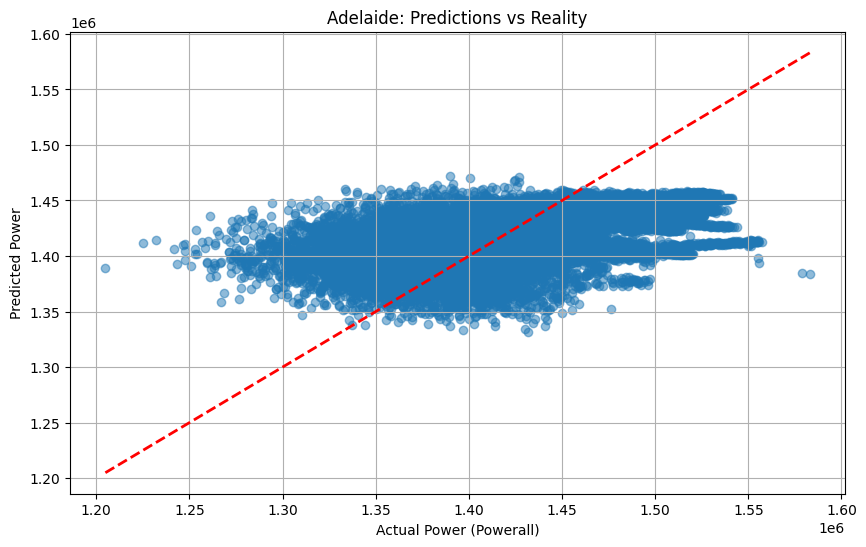

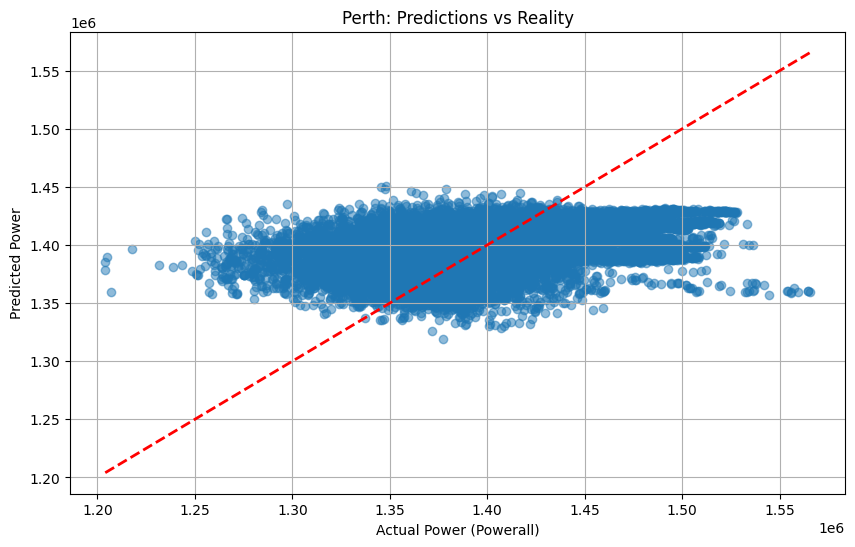

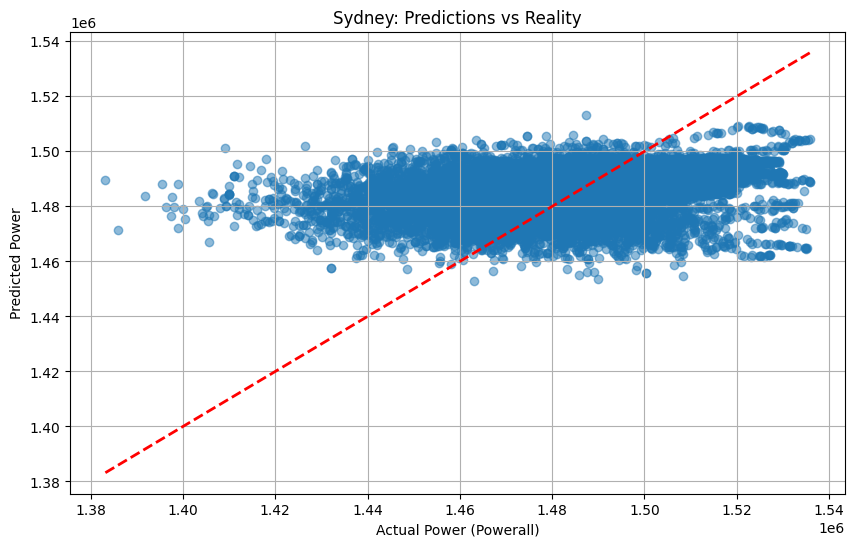

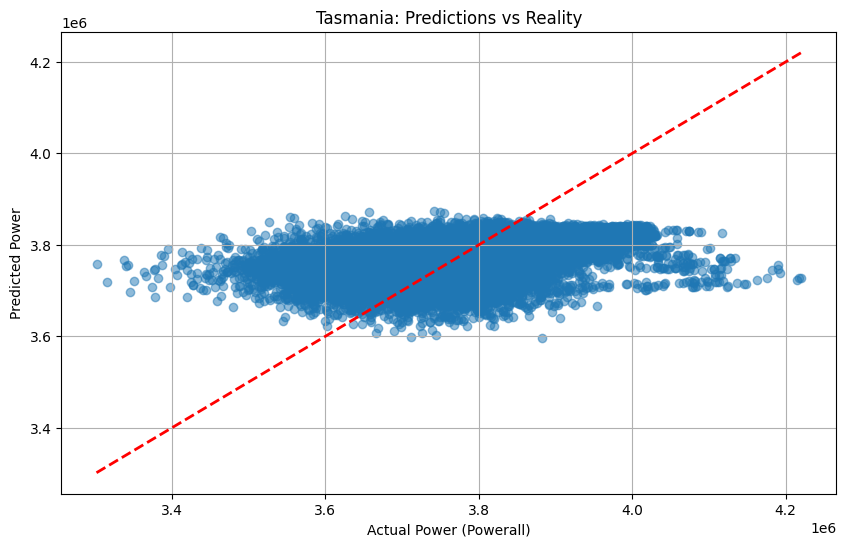

In [21]:
# Visualize
for i, dataset in enumerate(datasets):
    plt.figure(figsize=(10, 6))
    plt.scatter(lr_tests[i], lr_predictions[i], alpha=0.5)
    plt.plot([lr_tests[i].min(), lr_tests[i].max()], [lr_tests[i].min(), lr_tests[i].max()], 'r--', lw=2)
    plt.xlabel('Actual Power (Powerall)')
    plt.ylabel('Predicted Power')
    plt.title(f'{dataset.name}: Predictions vs Reality')
    plt.grid(True)
    plt.show()

# XGBoost
Using linear Regression resulted in an R2 score of around 0.17 at best, so we suspect the correlation between our variables may be more complicated than linear.


In [12]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

tests = []
predictions = []
models = []


for dataset in datasets:
    # Prepare features (x's and y's) and the target variable for every dataset
    features = [f'x{i}' for i in range(1, 17)] + [f'y{i}' for i in range(1, 17)]

    target = 'powerall'

    X = dataset[features].values
    y = dataset[target].values

    # Split train and test data

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

    tests.append(y_test)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the model
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=10,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=37,
    )

    # Make predictions on test set
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions.append(y_pred)
    models.append(model)


In [13]:
# Calculate evaluation metrics

mse_values = []
rmse_values = []
r2_values = []

for i, dataset in enumerate(datasets):
    prediction = predictions[i]
    actual = tests[i]

    mse = mean_squared_error(actual, prediction)
    mse_values.append(mse)

    rmse = np.sqrt(mse)
    rmse_values.append(rmse)

    r2 = r2_score(actual, prediction)
    r2_values.append(r2)

    print(f"Dataset {dataset.name}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")


Dataset Adelaide
MSE: 340729882.04
RMSE: 18458.87
R2: 0.8921
Dataset Perth
MSE: 359073114.09
RMSE: 18949.22
R2: 0.8696
Dataset Sydney
MSE: 40456986.48
RMSE: 6360.58
R2: 0.9244
Dataset Tasmania
MSE: 2492170614.12
RMSE: 49921.64
R2: 0.8027


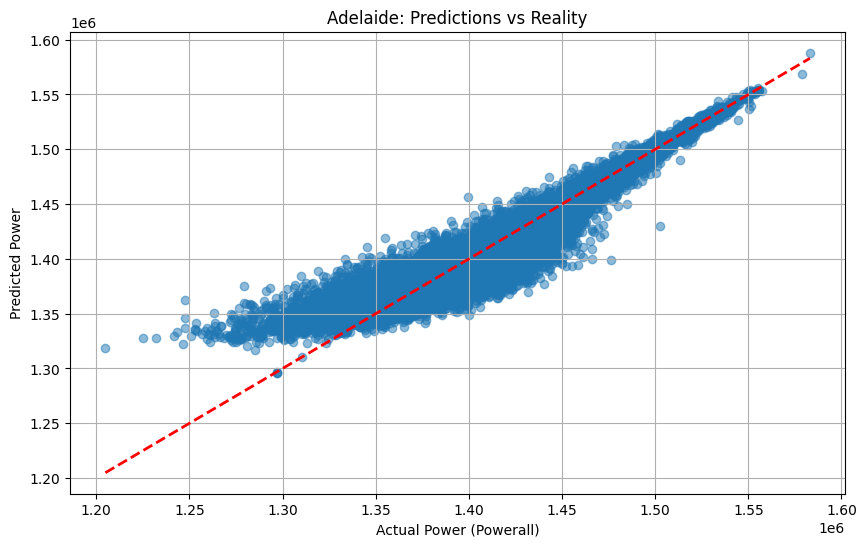

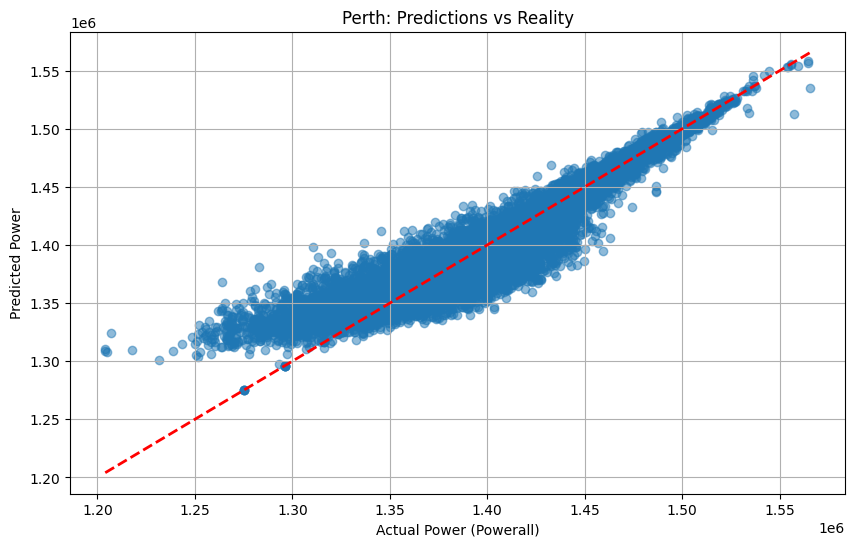

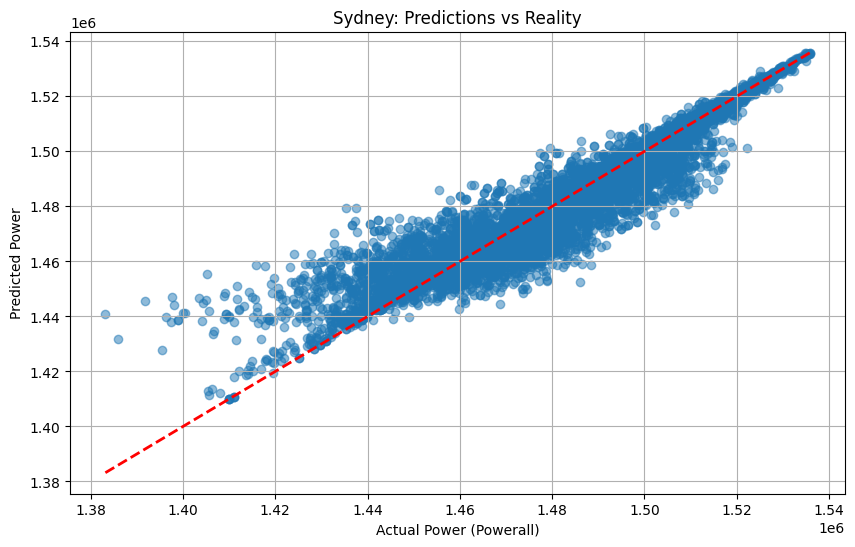

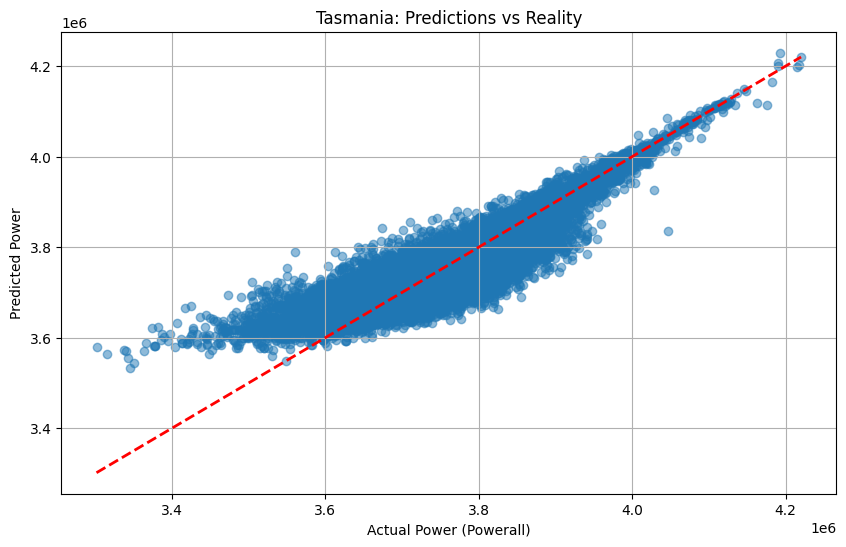

In [14]:
# Visualize predictions vs actual values

for i, dataset in enumerate(datasets):
    plt.figure(figsize=(10, 6))
    plt.scatter(tests[i], predictions[i], alpha=0.5)
    plt.plot([tests[i].min(), tests[i].max()], [tests[i].min(), tests[i].max()], 'r--', lw=2)
    plt.xlabel('Actual Power (Powerall)')
    plt.ylabel('Predicted Power')
    plt.title(f'{dataset.name}: Predictions vs Reality')
    plt.grid(True)
    plt.show()


Analysis for: Adelaide


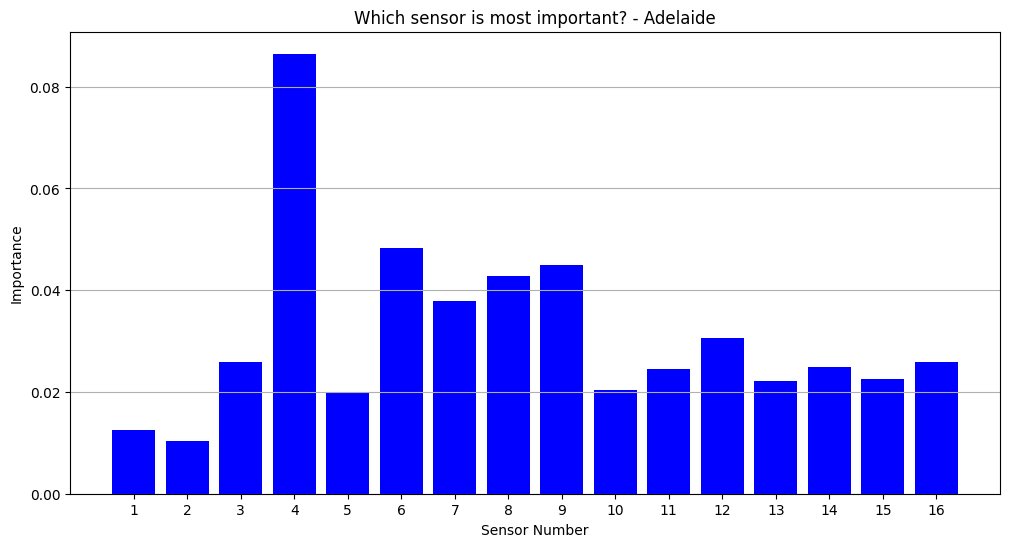

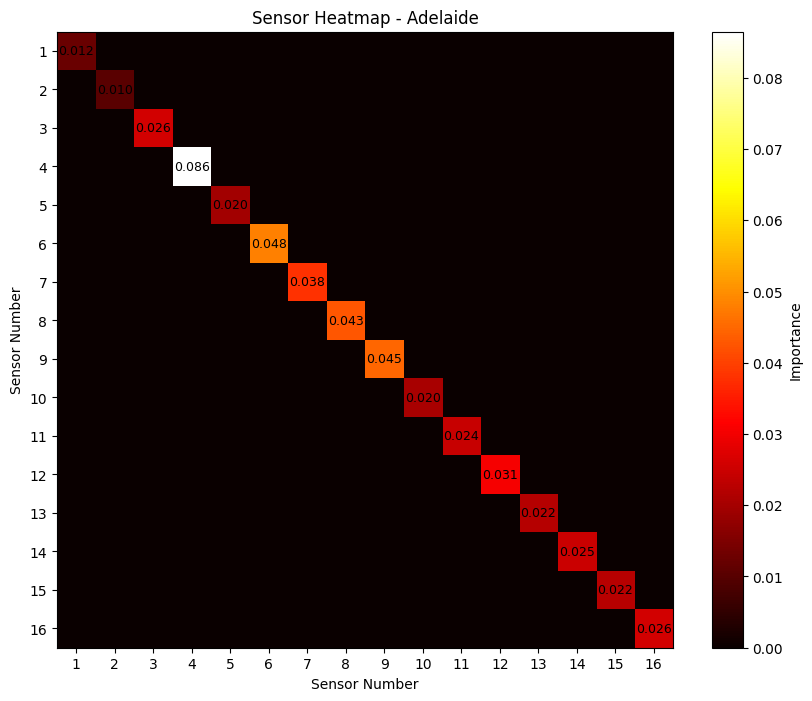


TOP 3 most important sensors:
1. Sensor 4: 0.0865
2. Sensor 6: 0.0482
3. Sensor 9: 0.0449


In [15]:
# (datasets: 0=Adelaide, 1=Perth, 2=Sydney, 3=Tasmania)
dataset_idx = 0
dataset = datasets[dataset_idx]
model = models[dataset_idx]

print(f"\nAnalysis for: {dataset.name}")

# get feature importances from the model
feature_importances = model.feature_importances_

# for each sensor, combine x and y importance
sensor_importances = []
for i in range(16):
    x_importance = feature_importances[i]       # x importance
    y_importance = feature_importances[i + 16]  # y importance
    combined = (x_importance + y_importance) / 2  # average
    sensor_importances.append(combined)

# plot 1: Bar chart
plt.figure(figsize=(12, 6))
plt.bar(range(1, 17), sensor_importances, color='blue')
plt.xlabel('Sensor Number')
plt.ylabel('Importance')
plt.title(f'Which sensor is most important? - {dataset.name}')
plt.xticks(range(1, 17))
plt.grid(axis='y')
plt.show()

# plot 2: Heatmap
importance_grid = np.diag(sensor_importances)

plt.figure(figsize=(10, 8))
plt.imshow(importance_grid, cmap='hot')
plt.colorbar(label='Importance')
plt.title(f'Sensor Heatmap - {dataset.name}')
plt.xlabel('Sensor Number')
plt.ylabel('Sensor Number')
plt.xticks(range(16), range(1, 17))
plt.yticks(range(16), range(1, 17))

# numbers for each cell
for i in range(16):
    for j in range(16):
        value = importance_grid[i, j]
        if value > 0:
            text_color = 'white' if value > 0.1 else 'black'
            plt.text(j, i, f'{value:.3f}',
                    ha='center', va='center',
                    color=text_color, fontsize=9)

plt.show()

# top 3 the most important sensors
top_3 = np.argsort(sensor_importances)[-3:][::-1]
print(f"\nTOP 3 most important sensors:")
for i, idx in enumerate(top_3, 1):
    print(f"{i}. Sensor {idx+1}: {sensor_importances[idx]:.4f}")

# 19.11.2025
todo:
- include linear regression for baseline
- run other models and compare
- change heatmap
- find out if the sensor importance chart is not an anomaly
